In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow import keras

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

print(X_train.shape, X_train.dtype)
print(Y_train.shape, Y_train.dtype)
print(X_test.shape, X_test.dtype)
print(Y_test.shape, Y_test.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


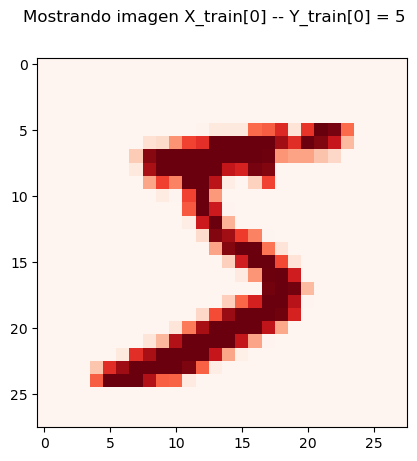

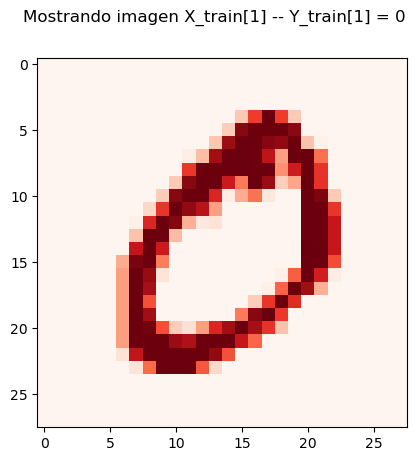

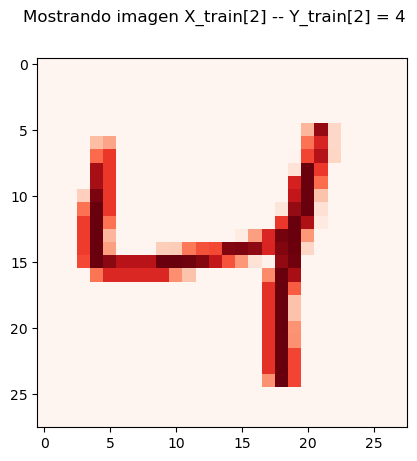

In [3]:
import matplotlib.pyplot as plt

def show_image(imagen, title):
    plt.figure()
    plt.suptitle(title)
    plt.imshow(imagen, cmap = "Reds")
    plt.show()
    
for i in range(3):
    title = "Mostrando imagen X_train[" + str(i) + "]"
    title = title + " -- Y_train[" + str(i) + "] = " + str(Y_train[i])
    show_image(X_train[i], title)

1


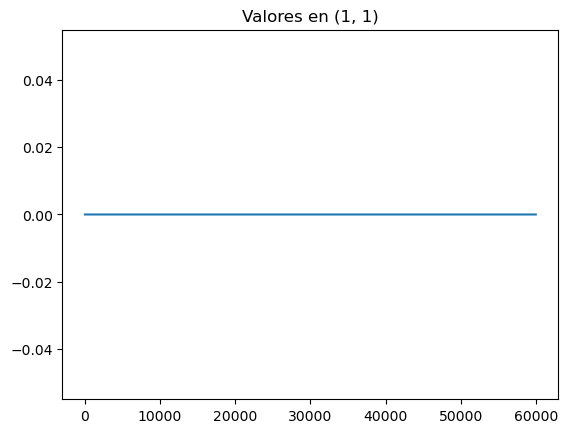

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_X(X, title, xscale, yscale):
    plt.title(title)
    plt.plot(X)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()

# Example values for fila and columna
fila = 1
columna = 1

features_fila_col = X_train[:, fila, columna]
print(len(np.unique(features_fila_col)))

title = "Valores en (" + str(fila) + ", " + str(columna) + ")"
xscale = "linear"  # Define the xscale
yscale = "linear"  # Define the yscale

plot_X(features_fila_col, title, xscale, yscale)


Tarea 1A: DecisionStump y ADABoost Binario sin mejoras

In [107]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones







In [53]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.10040000000000003, alpha = 1.096394005971338
Classifier 2/5: error = 0.40604910287750784, alpha = 0.19016127787705123
Classifier 3/5: error = 0.409483765601903, alpha = 0.18304993487365426
Classifier 4/5: error = 0.36892502319309606, alpha = 0.26841562167577754
Classifier 5/5: error = 0.35015228359697637, alpha = 0.3091849485023299
Accuracy for digit 3: 0.8999


In [70]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/5: error = 0.09710000000000002, alpha = 1.1149352145485212
Classifier 2/5: error = 0.24910277857941043, alpha = 0.5517016049094526
Classifier 3/5: error = 0.25113792231004006, alpha = 0.5462762724342984
Classifier 4/5: error = 0.2097760358286522, alpha = 0.6631379691659558
Classifier 5/5: error = 0.26394909070708433, alpha = 0.5127715200043861
Accuracy for digit 0: 0.9387
Running AdaBoost for digit: 1
Classifier 1/5: error = 0.11236666666666639, alpha = 1.0333957052290297
Classifier 2/5: error = 0.2770951393766059, alpha = 0.47945835643714435
Classifier 3/5: error = 0.3069714017074944, alpha = 0.40715833816673624
Classifier 4/5: error = 0.2254472969299921, alpha = 0.6170996449801985
Classifier 5/5: error = 0.26622834719840854, alpha = 0.506921745804049
Accuracy for digit 1: 0.9303
Running AdaBoost for digit: 2
Classifier 1/5: error = 0.09721666666666669, alpha = 1.1142702091197696
Classifier 2/5: error = 0.3519550869370178, alpha = 0.305228215

Tarea 1B: Experimentación con los parámetros T y A del método AdaboostBinario.predict

Tareas 1C y 1D: ADABoost Binario con mejoras y ADABoost Multiclase

Multiclase con ADABoosti Binario sin Mejoras

In [132]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [101]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.10195000000000003, alpha = 1.0878716240747428
Classifier 2/5: error = 0.3728798917346112, alpha = 0.25994086034772956
Classifier 3/5: error = 0.2842304738486725, alpha = 0.4617863936967898
Classifier 4/5: error = 0.36156201043210623, alpha = 0.2842954941802567
Classifier 5/5: error = 0.32246364143992123, alpha = 0.3712364133818312
Accuracy for digit 3: 0.9091


In [12]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/5: error = 0.08456666666666668, alpha = 1.1909286812500046
Classifier 2/5: error = 0.29146646227360073, alpha = 0.4441362235560382
Classifier 3/5: error = 0.32666047820497185, alpha = 0.36166417688270885
Classifier 4/5: error = 0.223298937479961, alpha = 0.623272071263118
Classifier 5/5: error = 0.31610110555740767, alpha = 0.38587398733811346
Accuracy for digit 0: 0.9301
Running AdaBoost for digit: 1
Classifier 1/5: error = 0.11236666666666639, alpha = 1.0333957052290297
Classifier 2/5: error = 0.24833056622544802, alpha = 0.5537679286778551
Classifier 3/5: error = 0.33639261386886643, alpha = 0.339705858520557
Classifier 4/5: error = 0.2963414554058441, alpha = 0.43239043068970323
Classifier 5/5: error = 0.3700460853606393, alpha = 0.26600955616080313
Accuracy for digit 1: 0.8865
Running AdaBoost for digit: 2
Classifier 1/5: error = 0.09920000000000004, alpha = 1.1030726210987731
Classifier 2/5: error = 0.3398451674462837, alpha = 0.33199213

In [134]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión

accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

Multiclass Accuracy: 0.828


Multiclase con ADABoosti Binario con Mejoras (Version 1: Solo añadido el parámetro n_componentes)

In [64]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [ ]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

In [65]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/5: error = 0.09864999999999968, alpha = 1.106157703038343
Classifier 2/5: error = 0.4168260383946094, alpha = 0.16790828576621425
Classifier 3/5: error = 0.4155014011399567, alpha = 0.1706341986059802
Classifier 4/5: error = 0.32761015727178433, alpha = 0.35950696933317167
Classifier 5/5: error = 0.3825069850253412, alpha = 0.23946042097636264
Accuracy for digit 0: 0.9024
Running AdaBoost for digit: 1
Classifier 1/5: error = 0.11239999999999972, alpha = 1.0332286264109174
Classifier 2/5: error = 0.4074839677960533, alpha = 0.18718817103171906
Classifier 3/5: error = 0.32954489696419453, alpha = 0.3551220686916899
Classifier 4/5: error = 0.4504496254078292, alpha = 0.09942709580368318
Classifier 5/5: error = 0.40627250906411805, alpha = 0.1896981527568554
Accuracy for digit 1: 0.8865
Running AdaBoost for digit: 2
Classifier 1/5: error = 0.09928333333333306, alpha = 1.1026065132210694
Classifier 2/5: error = 0.4126379248043841, alpha = 0.1765354

In [136]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    # Apply PCA
    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components)

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión


accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

Multiclass Accuracy: 0.8417


Multiclase con ADABoosti Binario con Mejoras (Version 1: Añadidos los parámetros n_componentes y k)

In [138]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos

def select_best_features(X_train, y_train, X_test, k=200): # Creamos la función select_best_features
    selector = SelectKBest(f_classif, k=k) # Creamos el objeto SelectKBest
    X_train_best = selector.fit_transform(X_train, y_train) # Seleccionamos las mejores características de los datos de entrenamiento
    X_test_best = selector.transform(X_test) # Seleccionamos las mejores características de los datos de prueba
    return X_train_best, X_test_best # Devolvemos los datos con las mejores características


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50, k=200): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos para reducir la dimensión de las imagénes a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos para reducir la dimensión de las imagénes a 1D

    X_train_best, X_test_best = select_best_features(X_train, y_train, X_test, k=k) # Seleccionamos las mejores características


    X_train_reduced, X_test_reduced = apply_pca(X_train_best, X_test_best, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [88]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.09578333333333311, alpha = 1.1224901549858723
Classifier 2/5: error = 0.423811546699126, alpha = 0.15357294594849832
Classifier 3/5: error = 0.44594286075021583, alpha = 0.10853849596112296
Classifier 4/5: error = 0.43261482746443425, alpha = 0.13559530076075985
Classifier 5/5: error = 0.47357464282143635, alpha = 0.05290000448255655
Accuracy for digit 3: 0.9003


In [89]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/5: error = 0.06493333333333336, alpha = 1.3336283620106117
Classifier 2/5: error = 0.40729086733956765, alpha = 0.18758809260424628
Classifier 3/5: error = 0.45367364809500965, alpha = 0.09291920425006518
Classifier 4/5: error = 0.36758716202838615, alpha = 0.2712909696472824
Classifier 5/5: error = 0.45306292554869954, alpha = 0.09415136693421174
Accuracy for digit 0: 0.934
Running AdaBoost for digit: 1
Classifier 1/5: error = 0.11243333333333305, alpha = 1.033061590861527
Classifier 2/5: error = 0.4453157110817808, alpha = 0.10980780466445449
Classifier 3/5: error = 0.1714455120615499, alpha = 0.7877085495093323
Classifier 4/5: error = 0.2813040656471276, alpha = 0.46900109941991674
Classifier 5/5: error = 0.4102413735063475, alpha = 0.18148382156901965
Accuracy for digit 1: 0.8865
Running AdaBoost for digit: 2
Classifier 1/5: error = 0.09931666666666639, alpha = 1.1024201675356724
Classifier 2/5: error = 0.40659765491248473, alpha = 0.18902

In [139]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50, k=200): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    X_train_best, X_test_best = select_best_features(X_train, y_train, X_test, k=k) # Seleccionamos las mejores características

    X_train_reduced, X_test_reduced = apply_pca(X_train_best, X_test_best, n_components=n_components) # Aplicamos PCA a los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión


accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 140 141 168 476 560 644 645 671 672 673 699 700 701 727
 728 729 730 754 755 756 757 758 759 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Multiclass Accuracy: 0.8016


Tarea 1E: Implementación de una versión de AdaboostBinario.fit que pare automáticamente el entrenamiento 
cuando detecte sobreentrenamiento.

In [76]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de iteraciones
        self.A = A # Inicializamos el número de clasificadores débiles
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones
    
    def compute_optimal_number_of_weak_classificators(self, X_verification, y_verification, X_test, y_test, 
                                                      iterNumber = 100, numberOfTries = 10):
        bestAccuracy = 0
        newAccuracy = 0
        optimalNumberOfWeakClassificators = 5
        
        while round(newAccuracy, 6) >= round(bestAccuracy, 6):
            optimalNumberOfWeakClassificators += 1
            bestAccuracy = newAccuracy
            newAccuracy = 0
            for i in range(iterNumber):
                adaboost = AdaBoost(T=optimalNumberOfWeakClassificators, A=numberOfTries)
                adaboost.fit(X_verification, y_verification)
                y_pred = adaboost.predict(X_test)
                partialAccuracy = np.sum(y_test == np.sign(y_pred)) / len(y_test)
                newAccuracy += partialAccuracy
            newAccuracy /= iterNumber
        self.T = optimalNumberOfWeakClassificators
        #return optimalNumberOfWeakClassificators

    
def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones



def run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
    digit, A=20, verboseParam=False, n_components=50, 
    split_proportion = 0.90, iterNumber = 100, numberOfTries = 10):
    
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    num_samples = len(X_train)
    split_point = int(split_proportion * num_samples)
    
    X_True_Train = X_train[:split_point]
    y_True_Train = y_train[:split_point]

    X_Verification = X_train[split_point:]
    y_verification = y_train[split_point:]

    X_True_Train = X_True_Train.reshape(X_True_Train.shape[0], -1) 
    X_Verification = X_Verification.reshape(X_Verification.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   

    X_true_train_reduced, X_test_train_reduced = apply_pca(X_True_Train, X_test, n_components=n_components) # Aplicamos PCA a los datos
    X_verification_reduced, X_test_verification_reduced = apply_pca(X_Verification, X_test, n_components=n_components) # Aplicamos PCA a los datos
    
    y_true_train_binary = np.where(y_True_Train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_verification_binary = np.where(y_verification == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 
    
    adaboost = AdaBoost(T=9, A=A)  # Creamos el clasificador AdaBoost
    
    adaboost.compute_optimal_number_of_weak_classificators(
        X_verification_reduced, y_verification_binary, X_test_verification_reduced, y_test_binary,
        iterNumber = iterNumber, numberOfTries = numberOfTries)
    
    print("The optimal number of weak classificators is: ", adaboost.T)
    
    adaboost.fit(X_true_train_reduced, y_true_train_binary, verboseParam)
    y_pred = adaboost.predict(X_test_train_reduced)
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}")
    
    return accuracy 

def run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators(
    A=20, verboseParam=False, n_components=50, 
    split_proportion = 0.90, iterNumber = 100, numberOfTries = 10):
    
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
            digit, A, verboseParam, n_components, split_proportion, iterNumber, numberOfTries)
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones
    
        

In [13]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.10220000000000003, alpha = 1.0865078238555685
Classifier 2/5: error = 0.45907977648290865, alpha = 0.08202390342839501
Classifier 3/5: error = 0.45479312565178, alpha = 0.09066133095088648
Classifier 4/5: error = 0.3101342671000804, alpha = 0.3997458325454976
Classifier 5/5: error = 0.3633968464888695, alpha = 0.28032549513346844
Accuracy for digit 3: 0.899


In [ ]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

In [63]:

accuracy = run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
    digit=3, A=20, verboseParam=True, 
    n_components=50, split_proportion=0.90,
    iterNumber = 100, numberOfTries=10)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
The optimal number of weak classificators is:  17
Classifier 1/17: error = 0.10194444444444443, alpha = 1.087901964400644
Classifier 2/17: error = 0.34560002671676904, alpha = 0.31921831504513715
Classifier 3/17: error = 0.46588563941735933, alpha = 0.06833488968314319
Classifier 4/17: error = 0.4420525373430926, alpha = 0.11641803358789393
Classifier 5/17: error = 0.44755337415987684, alpha = 0.1052805107002241
Classifier 6/17: error = 0.3244545036689971, alpha = 0.36668759257436545
Classifier 7/17: error = 0.31129076174639203, alpha = 0.397045887846209
Classifier 8/17: error = 0.41975517857760575, alpha = 0.16188924357088277
Classifier 9/17: error = 0.3006176930515007, alpha = 0.4221790959706896
Classifier 10/17: error = 0.38364975295086423, alpha = 0.23704267502283724
Classifier 11/17: error = 0.39128325820400905, alpha = 0.2209606479885551
Classifier 12/17: error = 0.44579062838969663, alpha = 0.10884657183830775
Classifier 13/17: error = 0.45143328981

In [77]:
all_accuracies =  run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators(
    A=100, verboseParam=True, 
    n_components=50, split_proportion=0.75,
    iterNumber = 500, numberOfTries=20)
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
The optimal number of weak classificators is:  39
Classifier 1/39: error = 0.06297777777777791, alpha = 1.349962533174085
Classifier 2/39: error = 0.3276461657948623, alpha = 0.3594252387546044
Classifier 3/39: error = 0.16950229757234683, alpha = 0.7945793401796725
Classifier 4/39: error = 0.26444298848034875, alpha = 0.5115011835952452
Classifier 5/39: error = 0.27570344434813643, alpha = 0.4829375522477364
Classifier 6/39: error = 0.3474599806450487, alpha = 0.31511148738232814
Classifier 7/39: error = 0.3773551309159446, alpha = 0.2503947933537895
Classifier 8/39: error = 0.39154301902246125, alpha = 0.2204154105251529
Classifier 9/39: error = 0.23531406409400277, alpha = 0.5892720715427484
Classifier 10/39: error = 0.353620535179336, alpha = 0.30158116718118344
Classifier 11/39: error = 0.37875856464271, alpha = 0.24741041079079598
Classifier 12/39: error = 0.40018971663230807, alpha = 0.20233734224888333
Classifier 13/39: error = 0.3887556762087032, 

KeyboardInterrupt: 